# Gaussian Process

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from addutils import css_notebook
from sklearn import metrics
import time
css_notebook()

In [3]:
import bokeh.plotting as bk
from bokeh import palettes
bk.output_notebook()

Loading BokehJS ...

In [4]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

## 1 Introduction

What is a **Gaussian Process (GP)**? A GP defines a prior over functions, which can be converted into a posterior over functions once we have seen some data. Although it might seem difficult to represent a distrubution over a function, it turns out that we only need to be able to define a distribution over the function’s values at a finite, but arbitrary, set of points, say $x_1, \ldots, x_N$. A GP assumes that $p(f(x_1), \ldots,f(x_N))$ is jointly Gaussian, with some mean $\mu(x)$ and covariance $\sum(x)$ given by $\sum_{ij}=k(x_i,x_j)$, where $k$ is a positive definite kernel function. The key idea is that if $x_i$ and $x_j$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too.

Very often, it’s assumed that the mean of this partner GP is zero everywhere. What
relates one observation to another in such cases is just the covariance function, $k(x, x')$. A popular choice is the "squared exponential"
$$k(x, x') = \sigma^2_f exp\bigg[ \frac{-(x-x')^2}{2l^2} \bigg]$$
where the maximum allowable covariance is defined as $\sigma_f^2$, this should be high for
functions which cover a broad range on the y axis. If $x \approx x'$ , then $k(x, x')$ approaches this maximum, meaning $f (x)$ is nearly perfectly correlated with $f (x')$. This is good: for our function to look smooth, neighbours must be alike. Now if $x$ is distant from $x'$, we have instead $k(x, x') \approx 0$, i.e. the two points cannot "see" each other. So, for example, during interpolation at new $x$ values, distant observations will have negligible effect. How much effect this separation has will depend on the length parameter, $l$, so there is much flexibility built into. 

To prepare for GPR, we calculate the covariance function, among all possible combinations of these points, summarizing our findings in three matrices:
$$K = 
 \begin{pmatrix}
  k(x_1,x_1) & k(x_1,x_2) & \cdots & k(x_1,x_n) \\
  k(x_2,x_1) & k(x_2,x_2) & \cdots & k(x_2,x_n) \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  k(x_m,x_1) & k(x_m,x_2) & \cdots & k(x_m,x_n) 
 \end{pmatrix}$$
 
$K_∗ = [k(x_∗ , x_1) k(x_∗ , x_2) \cdots k(x_∗ , x_n)]\quad K_{**} = k(x_*, x_*)$

$$ 
\Bigg[\begin{matrix}
y\\
y_*
\end{matrix}\Bigg] \approx \mathcal{N}\Bigg(0, \Bigg[ \begin{matrix} 
K & K_*^T \\
K_* & K_{**}
\end{matrix}\Bigg] \Bigg)
$$

## 2 Gaussian Process Regression

Gaussian Processes (GP) are a generic supervised learning method designed to solve regression and probabilistic classification problems.

The advantages of Gaussian processes are:

- The prediction interpolates the observations (at least for regular kernels).
- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit (online fitting, adaptive fitting) the prediction in some region of interest.
- Versatile: different kernels can be specified. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of Gaussian processes include:

- They are not sparse, i.e., they use the whole samples/features information to perform the prediction.
- They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

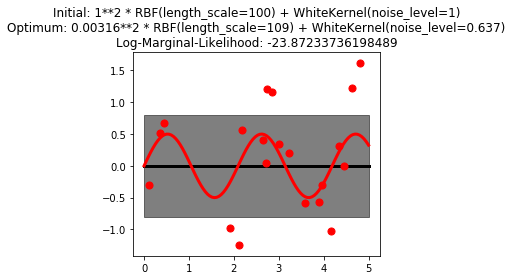

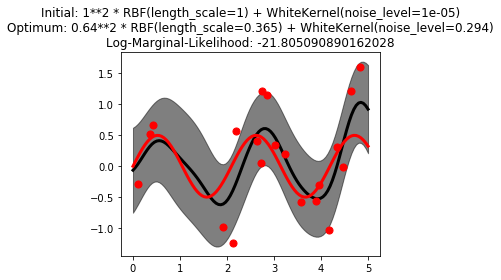

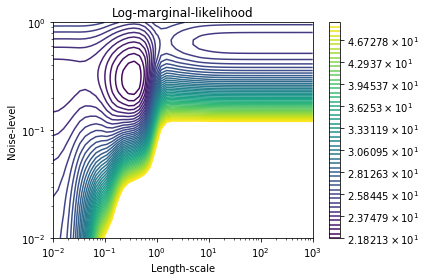

In [5]:
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure(0)
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10)
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10)
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure(2)
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
plt.contour(Theta0, Theta1, -LML,
            levels=np.logspace(np.log10(vmin), np.log10(vmax), 50),
            norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

### 2.1 Comparison with Ridge Regression

Time for KRR fitting: 4.067
Time for GPR fitting: 0.095
Time for KRR prediction: 0.050
Time for GPR prediction: 0.053
Time for GPR prediction with standard-deviation: 0.062


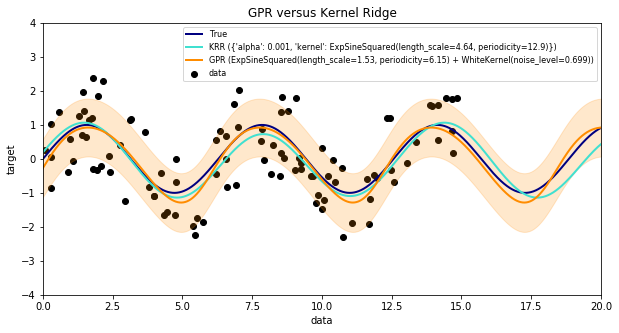

In [6]:
%matplotlib inline
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using kernel ridge
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

---

Visit [www.add-for.com](<http://www.add-for.com/>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.